In [75]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt

In [76]:
from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import get_regression_metrics

In [77]:
torch.manual_seed(42)
np.random.seed(42)

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
dataset = FPbase('data/dataset.csv')

In [80]:
x_train, y_train = dataset.get_train('em_max')
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)
x_test, y_test = dataset.get_test('em_max')

In [81]:
# Define the amino acid alphabet
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}

def sequence_to_tensor(sequence, max_length=500):
    """Convert a protein sequence string to a one-hot encoded tensor."""
    # Truncate if too long
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    
    # Create one-hot encoding
    tensor = torch.zeros(max_length, len(AMINO_ACIDS))
    
    for i, aa in enumerate(sequence):
        if aa in AA_TO_IDX:
            tensor[i, AA_TO_IDX[aa]] = 1.0
    
    return tensor

def preprocessing_x(sequences, max_length=500):
    if isinstance(sequences, pd.Series):
        sequences = sequences.reset_index(drop=True).tolist()

    sequence_tensors = torch.stack([sequence_to_tensor(seq, max_length) for seq in sequences])
    
    return sequence_tensors


In [82]:
x_train_p, x_test_p, x_val_p = preprocessing_x(x_train), preprocessing_x(x_test), preprocessing_x(x_val)
y_train_p, y_test_p, y_val_p = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

In [83]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(x_train_p, y_train_p)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test_p, y_test_p)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

dataset_val = TensorDataset(x_val_p, y_val_p)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [84]:
class ProteinCNN(nn.Module):
    def __init__(self, num_amino_acids=20, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) 
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

In [85]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, filename='best_model.pth'):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.cuda.set_device(0)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    criterion = nn.MSELoss()
    
    # Early stopping to prevent overfitting
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20
    
    # Track training history
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Starting training...")
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_batches = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            predictions = model(sequences)
            
            loss = criterion(predictions.squeeze(), targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval() 
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad(): 
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
        print('-' * 50)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), filename)
            print(f'New best model saved with validation loss: {best_val_loss:.6f}')
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    model.load_state_dict(torch.load(filename))
    return model, train_losses, val_losses, learning_rates

In [86]:
def evaluate_model(model, data_loader, fpbase_dataset, target_name='ex_max'):
    """
    Evaluate the trained model and calculate performance metrics.
    
    This function provides comprehensive evaluation including predictions
    on both normalized and original scales using FPbase rescaling.
    
    Args:
        model: The trained model
        data_loader: DataLoader with test/validation data
        dataset: ProteinDataset instance
        fpbase_dataset: FPbase instance for proper rescaling
        target_name: Name of the target property (default: 'ex_max')
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    metrics_normalized = get_regression_metrics(all_predictions, all_targets)
    targets_original = fpbase_dataset.rescale_targets(all_targets, target_name)
    predictions_original = fpbase_dataset.rescale_targets(all_predictions, target_name)
    
    metrics_original = get_regression_metrics(predictions_original, targets_original)
    
    print("\nModel Evaluation Results:")
    print(f"Normalized metrics:")
    print(f"  R² Score: {metrics_normalized['r2']:.4f}")
    print(f"  RMSE: {metrics_normalized['rmse']:.4f}")
    print(f"  MAE: {metrics_normalized['mae']:.4f}")
    print(f"  Median AE: {metrics_normalized['mae_median']:.4f}")
    
    print(f"\nOriginal scale metrics:")
    print(f"  R² Score: {metrics_original['r2']:.4f}")
    print(f"  RMSE: {metrics_original['rmse']:.4f}")
    print(f"  MAE: {metrics_original['mae']:.4f}")
    print(f"  Median AE: {metrics_original['mae_median']:.4f}")
    
    return {
        'predictions_original': predictions_original,
        'targets_original': targets_original,
        **{f"{k}_original": v for k, v in metrics_original.items()},
        **{f"{k}_normalized": v for k, v in metrics_normalized.items()}
    }

def plot_training_history(train_losses, val_losses, learning_rates):
    """
    Visualize the training process to understand model behavior.
    
    These plots help you understand whether your model is learning properly,
    overfitting, or if you need to adjust hyperparameters.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot learning rate schedule
    axes[0, 1].plot(learning_rates, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True)
    
    # Plot loss difference (overfitting indicator)
    loss_diff = np.array(val_losses) - np.array(train_losses)
    axes[1, 0].plot(loss_diff, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss - Training Loss')
    axes[1, 0].set_title('Overfitting Indicator')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True)
    
    # Plot validation loss with trend
    axes[1, 1].plot(val_losses, color='red', alpha=0.7)
    # Add trend line
    z = np.polyfit(range(len(val_losses)), val_losses, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(range(len(val_losses)), p(range(len(val_losses))), 
                   color='black', linestyle='--', label='Trend')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Validation Loss with Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [87]:
model = ProteinCNN(
    num_amino_acids=20, 
    num_filters=128,
    dropout_rate=0.5
).to(device)

trained_model, train_losses, val_losses, learning_rates = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.001
)

Starting training...
Training batches per epoch: 17
Validation batches per epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\User\Desktop\biocadprotein\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/200 [00:00<00:55,  3.60it/s]

Epoch 1/200:
  Train Loss: 0.847335
  Val Loss: 0.957104
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.957104


  1%|          | 2/200 [00:00<00:52,  3.77it/s]

Epoch 2/200:
  Train Loss: 0.563537
  Val Loss: 0.555787
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.555787


  2%|▏         | 3/200 [00:00<00:52,  3.74it/s]

Epoch 3/200:
  Train Loss: 0.501120
  Val Loss: 1.944694
  Learning Rate: 0.00100000
--------------------------------------------------


  2%|▏         | 4/200 [00:01<00:50,  3.85it/s]

Epoch 4/200:
  Train Loss: 0.452602
  Val Loss: 8.691928
  Learning Rate: 0.00100000
--------------------------------------------------


  2%|▎         | 5/200 [00:01<00:49,  3.97it/s]

Epoch 5/200:
  Train Loss: 0.428423
  Val Loss: 7.463689
  Learning Rate: 0.00100000
--------------------------------------------------


  3%|▎         | 6/200 [00:01<00:49,  3.96it/s]

Epoch 6/200:
  Train Loss: 0.427011
  Val Loss: 0.638714
  Learning Rate: 0.00100000
--------------------------------------------------


  4%|▎         | 7/200 [00:01<00:49,  3.87it/s]

Epoch 7/200:
  Train Loss: 0.479275
  Val Loss: 0.337544
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.337544


  4%|▍         | 8/200 [00:02<00:50,  3.83it/s]

Epoch 8/200:
  Train Loss: 0.403593
  Val Loss: 2.819284
  Learning Rate: 0.00100000
--------------------------------------------------


  4%|▍         | 9/200 [00:02<00:49,  3.84it/s]

Epoch 9/200:
  Train Loss: 0.400213
  Val Loss: 0.321612
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.321612


  5%|▌         | 10/200 [00:02<00:49,  3.86it/s]

Epoch 10/200:
  Train Loss: 0.377240
  Val Loss: 0.630353
  Learning Rate: 0.00100000
--------------------------------------------------


  6%|▌         | 11/200 [00:02<00:48,  3.93it/s]

Epoch 11/200:
  Train Loss: 0.351269
  Val Loss: 0.827919
  Learning Rate: 0.00100000
--------------------------------------------------


  6%|▌         | 12/200 [00:03<00:46,  4.02it/s]

Epoch 12/200:
  Train Loss: 0.340220
  Val Loss: 0.489986
  Learning Rate: 0.00100000
--------------------------------------------------


  6%|▋         | 13/200 [00:03<00:46,  4.04it/s]

Epoch 13/200:
  Train Loss: 0.334787
  Val Loss: 1.559823
  Learning Rate: 0.00100000
--------------------------------------------------


  7%|▋         | 14/200 [00:03<00:45,  4.08it/s]

Epoch 14/200:
  Train Loss: 0.293433
  Val Loss: 0.229537
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.229537


  8%|▊         | 15/200 [00:03<00:44,  4.12it/s]

Epoch 15/200:
  Train Loss: 0.263075
  Val Loss: 0.527565
  Learning Rate: 0.00100000
--------------------------------------------------


  8%|▊         | 16/200 [00:04<00:44,  4.15it/s]

Epoch 16/200:
  Train Loss: 0.273889
  Val Loss: 0.765723
  Learning Rate: 0.00100000
--------------------------------------------------


  8%|▊         | 17/200 [00:04<00:44,  4.16it/s]

Epoch 17/200:
  Train Loss: 0.363506
  Val Loss: 0.475914
  Learning Rate: 0.00100000
--------------------------------------------------


  9%|▉         | 18/200 [00:04<00:43,  4.14it/s]

Epoch 18/200:
  Train Loss: 0.415994
  Val Loss: 0.212304
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.212304


 10%|▉         | 19/200 [00:04<00:43,  4.16it/s]

Epoch 19/200:
  Train Loss: 0.246362
  Val Loss: 0.303342
  Learning Rate: 0.00100000
--------------------------------------------------


 10%|█         | 20/200 [00:04<00:43,  4.18it/s]

Epoch 20/200:
  Train Loss: 0.268393
  Val Loss: 0.576336
  Learning Rate: 0.00100000
--------------------------------------------------


 10%|█         | 21/200 [00:05<00:42,  4.17it/s]

Epoch 21/200:
  Train Loss: 0.237093
  Val Loss: 0.241717
  Learning Rate: 0.00100000
--------------------------------------------------


 11%|█         | 22/200 [00:05<00:42,  4.15it/s]

Epoch 22/200:
  Train Loss: 0.218307
  Val Loss: 0.218587
  Learning Rate: 0.00100000
--------------------------------------------------


 12%|█▏        | 23/200 [00:05<00:42,  4.12it/s]

Epoch 23/200:
  Train Loss: 0.265610
  Val Loss: 0.215541
  Learning Rate: 0.00100000
--------------------------------------------------


 12%|█▏        | 24/200 [00:05<00:43,  4.09it/s]

Epoch 24/200:
  Train Loss: 0.208966
  Val Loss: 0.279787
  Learning Rate: 0.00100000
--------------------------------------------------


 12%|█▎        | 25/200 [00:06<00:43,  4.06it/s]

Epoch 25/200:
  Train Loss: 0.305521
  Val Loss: 3.388375
  Learning Rate: 0.00100000
--------------------------------------------------


 13%|█▎        | 26/200 [00:06<00:42,  4.09it/s]

Epoch 26/200:
  Train Loss: 0.223210
  Val Loss: 2.193928
  Learning Rate: 0.00100000
--------------------------------------------------


 14%|█▎        | 27/200 [00:06<00:42,  4.04it/s]

Epoch 27/200:
  Train Loss: 0.204034
  Val Loss: 1.836468
  Learning Rate: 0.00100000
--------------------------------------------------


 14%|█▍        | 28/200 [00:06<00:42,  4.05it/s]

Epoch 28/200:
  Train Loss: 0.289460
  Val Loss: 0.379199
  Learning Rate: 0.00100000
--------------------------------------------------


 14%|█▍        | 29/200 [00:07<00:41,  4.10it/s]

Epoch 29/200:
  Train Loss: 0.630721
  Val Loss: 0.997933
  Learning Rate: 0.00100000
--------------------------------------------------


 15%|█▌        | 30/200 [00:07<00:41,  4.12it/s]

Epoch 30/200:
  Train Loss: 0.248592
  Val Loss: 0.209874
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.209874


 16%|█▌        | 31/200 [00:07<00:41,  4.10it/s]

Epoch 31/200:
  Train Loss: 0.202602
  Val Loss: 0.169506
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.169506


 16%|█▌        | 32/200 [00:07<00:40,  4.13it/s]

Epoch 32/200:
  Train Loss: 0.271185
  Val Loss: 0.384531
  Learning Rate: 0.00100000
--------------------------------------------------


 16%|█▋        | 33/200 [00:08<00:40,  4.15it/s]

Epoch 33/200:
  Train Loss: 0.189048
  Val Loss: 0.231135
  Learning Rate: 0.00100000
--------------------------------------------------


 17%|█▋        | 34/200 [00:08<00:39,  4.17it/s]

Epoch 34/200:
  Train Loss: 0.161543
  Val Loss: 7.870188
  Learning Rate: 0.00100000
--------------------------------------------------


 18%|█▊        | 35/200 [00:08<00:39,  4.20it/s]

Epoch 35/200:
  Train Loss: 0.212509
  Val Loss: 0.201984
  Learning Rate: 0.00100000
--------------------------------------------------


 18%|█▊        | 36/200 [00:08<00:39,  4.17it/s]

Epoch 36/200:
  Train Loss: 0.205457
  Val Loss: 0.335643
  Learning Rate: 0.00100000
--------------------------------------------------


 18%|█▊        | 37/200 [00:09<00:39,  4.15it/s]

Epoch 37/200:
  Train Loss: 0.171530
  Val Loss: 0.845686
  Learning Rate: 0.00100000
--------------------------------------------------


 19%|█▉        | 38/200 [00:09<00:39,  4.15it/s]

Epoch 38/200:
  Train Loss: 0.230723
  Val Loss: 0.669496
  Learning Rate: 0.00100000
--------------------------------------------------


 20%|█▉        | 39/200 [00:09<00:38,  4.16it/s]

Epoch 39/200:
  Train Loss: 0.215607
  Val Loss: 0.212467
  Learning Rate: 0.00100000
--------------------------------------------------


 20%|██        | 40/200 [00:09<00:38,  4.15it/s]

Epoch 40/200:
  Train Loss: 0.202078
  Val Loss: 0.377693
  Learning Rate: 0.00100000
--------------------------------------------------


 20%|██        | 41/200 [00:10<00:38,  4.18it/s]

Epoch 41/200:
  Train Loss: 0.185309
  Val Loss: 0.195667
  Learning Rate: 0.00100000
--------------------------------------------------


 21%|██        | 42/200 [00:10<00:37,  4.18it/s]

Epoch 42/200:
  Train Loss: 0.183789
  Val Loss: 0.216539
  Learning Rate: 0.00100000
--------------------------------------------------


 22%|██▏       | 43/200 [00:10<00:37,  4.20it/s]

Epoch 43/200:
  Train Loss: 0.216104
  Val Loss: 0.200351
  Learning Rate: 0.00100000
--------------------------------------------------


 22%|██▏       | 44/200 [00:10<00:37,  4.21it/s]

Epoch 44/200:
  Train Loss: 0.208518
  Val Loss: 0.522971
  Learning Rate: 0.00100000
--------------------------------------------------


 22%|██▎       | 45/200 [00:11<00:36,  4.21it/s]

Epoch 45/200:
  Train Loss: 0.241614
  Val Loss: 0.201535
  Learning Rate: 0.00100000
--------------------------------------------------


 23%|██▎       | 46/200 [00:11<00:37,  4.16it/s]

Epoch 46/200:
  Train Loss: 0.174006
  Val Loss: 0.166914
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.166914


 24%|██▎       | 47/200 [00:11<00:37,  4.07it/s]

Epoch 47/200:
  Train Loss: 0.166633
  Val Loss: 0.284952
  Learning Rate: 0.00100000
--------------------------------------------------


 24%|██▍       | 48/200 [00:11<00:36,  4.13it/s]

Epoch 48/200:
  Train Loss: 0.164234
  Val Loss: 0.504789
  Learning Rate: 0.00100000
--------------------------------------------------


 24%|██▍       | 49/200 [00:12<00:36,  4.15it/s]

Epoch 49/200:
  Train Loss: 0.176761
  Val Loss: 0.464605
  Learning Rate: 0.00100000
--------------------------------------------------


 25%|██▌       | 50/200 [00:12<00:35,  4.17it/s]

Epoch 50/200:
  Train Loss: 0.179442
  Val Loss: 0.167050
  Learning Rate: 0.00100000
--------------------------------------------------


 26%|██▌       | 51/200 [00:12<00:35,  4.20it/s]

Epoch 51/200:
  Train Loss: 0.135188
  Val Loss: 0.220257
  Learning Rate: 0.00100000
--------------------------------------------------


 26%|██▌       | 52/200 [00:12<00:35,  4.21it/s]

Epoch 52/200:
  Train Loss: 0.140627
  Val Loss: 0.186930
  Learning Rate: 0.00100000
--------------------------------------------------


 26%|██▋       | 53/200 [00:12<00:35,  4.20it/s]

Epoch 53/200:
  Train Loss: 0.150689
  Val Loss: 0.291248
  Learning Rate: 0.00100000
--------------------------------------------------


 27%|██▋       | 54/200 [00:13<00:34,  4.21it/s]

Epoch 54/200:
  Train Loss: 0.148150
  Val Loss: 0.280939
  Learning Rate: 0.00100000
--------------------------------------------------


 28%|██▊       | 55/200 [00:13<00:34,  4.23it/s]

Epoch 55/200:
  Train Loss: 0.144480
  Val Loss: 1.290843
  Learning Rate: 0.00100000
--------------------------------------------------


 28%|██▊       | 56/200 [00:13<00:34,  4.23it/s]

Epoch 56/200:
  Train Loss: 0.194253
  Val Loss: 0.537338
  Learning Rate: 0.00100000
--------------------------------------------------


 28%|██▊       | 57/200 [00:13<00:33,  4.21it/s]

Epoch 57/200:
  Train Loss: 0.144134
  Val Loss: 0.361818
  Learning Rate: 0.00100000
--------------------------------------------------


 29%|██▉       | 58/200 [00:14<00:33,  4.24it/s]

Epoch 58/200:
  Train Loss: 0.178808
  Val Loss: 0.184627
  Learning Rate: 0.00100000
--------------------------------------------------


 30%|██▉       | 59/200 [00:14<00:33,  4.24it/s]

Epoch 59/200:
  Train Loss: 0.150971
  Val Loss: 0.858436
  Learning Rate: 0.00100000
--------------------------------------------------


 30%|███       | 60/200 [00:14<00:32,  4.25it/s]

Epoch 60/200:
  Train Loss: 0.145421
  Val Loss: 0.252732
  Learning Rate: 0.00100000
--------------------------------------------------


 30%|███       | 61/200 [00:14<00:32,  4.23it/s]

Epoch 61/200:
  Train Loss: 0.221305
  Val Loss: 4.027307
  Learning Rate: 0.00100000
--------------------------------------------------


 31%|███       | 62/200 [00:15<00:32,  4.23it/s]

Epoch 62/200:
  Train Loss: 0.167217
  Val Loss: 0.225309
  Learning Rate: 0.00100000
--------------------------------------------------


 32%|███▏      | 63/200 [00:15<00:32,  4.24it/s]

Epoch 63/200:
  Train Loss: 0.128492
  Val Loss: 0.320639
  Learning Rate: 0.00100000
--------------------------------------------------


 32%|███▏      | 64/200 [00:15<00:32,  4.23it/s]

Epoch 64/200:
  Train Loss: 0.182909
  Val Loss: 0.168797
  Learning Rate: 0.00100000
--------------------------------------------------


 32%|███▎      | 65/200 [00:15<00:31,  4.25it/s]

Epoch 65/200:
  Train Loss: 0.134741
  Val Loss: 0.397708
  Learning Rate: 0.00100000
--------------------------------------------------


 32%|███▎      | 65/200 [00:16<00:33,  4.06it/s]

Epoch 66/200:
  Train Loss: 0.142612
  Val Loss: 0.611769
  Learning Rate: 0.00100000
--------------------------------------------------
Early stopping triggered after 66 epochs



Evaluating model on test set...

Model Evaluation Results:
Normalized metrics:
  R² Score: 0.7875
  RMSE: 0.4361
  MAE: 0.2782
  Median AE: 0.1552

Original scale metrics:
  R² Score: 0.7875
  RMSE: 29.1424
  MAE: 18.5930
  Median AE: 10.3706


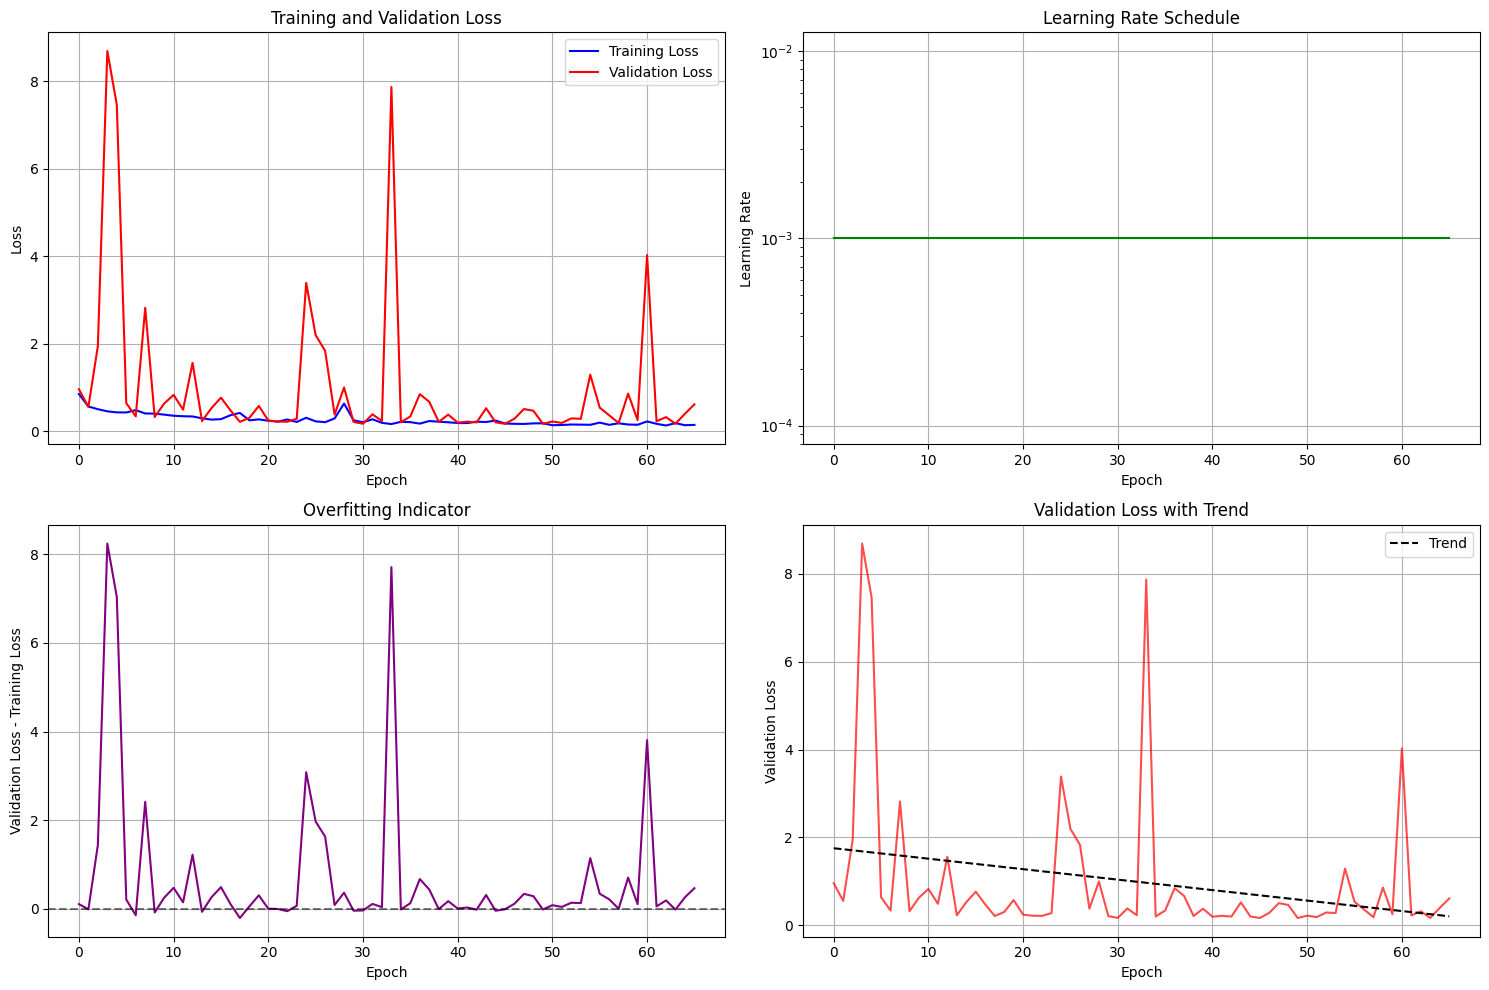

In [89]:
print("\nEvaluating model on test set...")
evaluation_results = evaluate_model(
    model=trained_model,
    data_loader=test_loader,
    fpbase_dataset=dataset,
    target_name='ex_max'
)

# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)